<a href="https://colab.research.google.com/github/nguyenhuy-vn/Finger-identification-based-on-capacitives-touch-screen/blob/main/vgg5_with_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras import datasets, models, layers

### Load data

In [3]:
X_train = np.load('/content/drive/MyDrive/data for 10/X_train.npy')
X_test = np.load('/content/drive/MyDrive/data for 10/X_test.npy')
X_val = np.load('/content/drive/MyDrive/data for 10/X_val.npy')
Y_train = np.load('/content/drive/MyDrive/data for 10/Y_train.npy')
Y_test = np.load('/content/drive/MyDrive/data for 10/Y_test.npy')
Y_val = np.load('/content/drive/MyDrive/data for 10/Y_val.npy')
label = np.load('/content/drive/MyDrive/data for 10/label.npy')

### Check if have any missing data

In [4]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((295791, 32, 32),
 (85970, 32, 32),
 (73948, 32, 32),
 (295791, 10),
 (85970, 10),
 (73948, 10))

In [5]:
X_train[0]

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.01568628, 0.01568628,
        0.01568628],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.01568628, 0.01568628,
        0.01568628],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.01568628, 0.01568628,
        0.01568628],
       ...,
       [0.09019608, 0.09019608, 0.09019608, ..., 0.2784314 , 0.2784314 ,
        0.2784314 ],
       [0.09019608, 0.09019608, 0.09019608, ..., 0.2784314 , 0.2784314 ,
        0.2784314 ],
       [0.09019608, 0.09019608, 0.09019608, ..., 0.2784314 , 0.2784314 ,
        0.2784314 ]], dtype=float32)

In [6]:
X_val[0]

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.02745098, 0.02745098,
        0.02745098],
       ...,
       [0.01568628, 0.01568628, 0.01568628, ..., 0.08627451, 0.08627451,
        0.08627451],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.08627451, 0.08627451,
        0.08627451],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.08627451, 0.08627451,
        0.08627451]], dtype=float32)

In [7]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

### Model and Train

In [8]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0],32,32,1)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [10]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.models import Model
import tensorflow as tf

class VGG5(Model):
    def __init__(self, num_classes, **kwargs):
        """
        num_classes: number of classes in specific classification task
        """
        super().__init__(**kwargs)

        # Define the convolutional layers with Batch Normalization
        self.conv1 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn2 = BatchNormalization()
        self.pool1 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')

        self.conv3 = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn3 = BatchNormalization()
        self.conv4 = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn4 = BatchNormalization()
        self.pool2 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')

        self.conv5 = Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn5 = BatchNormalization()
        self.pool3 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')

        # Define the fully connected layers with Batch Normalization
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.bn_fc1 = BatchNormalization()
        self.fc2 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        out = self.conv1(inputs)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.pool1(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.pool2(out)

        out = self.conv5(out)
        out = self.bn5(out)
        out = self.pool3(out)

        out = self.flatten(out)
        out = self.fc1(out)
        out = self.bn_fc1(out)
        out = self.fc2(out)

        return out



In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [12]:
model = VGG5(10)
model.build(input_shape = (None, 32, 32, 1))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy", f1_m, precision_m, recall_m])
model.summary()

Model: "vgg5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  640       
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           multiple                  36928     
                                                                 
 batch_normalization_1 (Bat  multiple                  256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                              

In [13]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs= 50, validation_data=(X_val, Y_val),callbacks=[es])

Epoch 1/50
1156/1155 [==============================] - ETA: 0s - loss: 1.8298 - accuracy: 0.3418 - f1_m: 0.1985 - precision_m: 0.6416 - recall_m: 0.1203

1155/1155 [==============================] - 123s 96ms/step - loss: 1.8298 - accuracy: 0.3418 - f1_m: 0.1985 - precision_m: 0.6416 - recall_m: 0.1203 - val_loss: 1.5999 - val_accuracy: 0.4173 - val_f1_m: 0.3186 - val_precision_m: 0.6975 - val_recall_m: 0.2069
Epoch 2/50
1156/1155 [==============================] - ETA: 0s - loss: 1.4869 - accuracy: 0.4625 - f1_m: 0.3633 - precision_m: 0.7176 - recall_m: 0.2442

1155/1155 [==============================] - 106s 91ms/step - loss: 1.4869 - accuracy: 0.4625 - f1_m: 0.3633 - precision_m: 0.7176 - recall_m: 0.2442 - val_loss: 1.4876 - val_accuracy: 0.4612 - val_f1_m: 0.3896 - val_precision_m: 0.6784 - val_recall_m: 0.2737
Epoch 3/50
1156/1155 [==============================] - ETA: 0s - loss: 1.3363 - accuracy: 0.5183 - f1_m: 0.4497 - precision_m: 0.7355 - recall_m: 0.3246

1155/1155 [==============================] - 105s 91ms/step - loss: 1.3363 - accuracy: 0.5183 - f1_m: 0.4497 - precision_m: 0.7355 - recall_m: 0.3246 - val_loss: 1.2986 - val_accuracy: 0.5320 - val_f1_m: 0.4718 - val_precision_m: 0.7522 - val_recall_m: 0.3442
Epoch 4/50
1156/1155 [==============================] - ETA: 0s - loss: 1.2350 - accuracy: 0.5564 - f1_m: 0.5075 - precision_m: 0.7539 - recall_m: 0.3830

1155/1155 [==============================] - 106s 91ms/step - loss: 1.2350 - accuracy: 0.5564 - f1_m: 0.5075 - precision_m: 0.7539 - recall_m: 0.3830 - val_loss: 1.2314 - val_accuracy: 0.5590 - val_f1_m: 0.5155 - val_precision_m: 0.7431 - val_recall_m: 0.3951
Epoch 5/50
1156/1155 [==============================] - ETA: 0s - loss: 1.1564 - accuracy: 0.5856 - f1_m: 0.5482 - precision_m: 0.7673 - recall_m: 0.4268

1155/1155 [==============================] - 105s 90ms/step - loss: 1.1564 - accuracy: 0.5856 - f1_m: 0.5482 - precision_m: 0.7673 - recall_m: 0.4268 - val_loss: 1.1924 - val_accuracy: 0.5740 - val_f1_m: 0.5425 - val_precision_m: 0.7448 - val_recall_m: 0.4271
Epoch 6/50
1156/1155 [==============================] - ETA: 0s - loss: 1.0968 - accuracy: 0.6087 - f1_m: 0.5791 - precision_m: 0.7781 - recall_m: 0.4616

1155/1155 [==============================] - 107s 92ms/step - loss: 1.0968 - accuracy: 0.6087 - f1_m: 0.5791 - precision_m: 0.7781 - recall_m: 0.4616 - val_loss: 1.1710 - val_accuracy: 0.5843 - val_f1_m: 0.5501 - val_precision_m: 0.7463 - val_recall_m: 0.4360
Epoch 7/50
1156/1155 [==============================] - ETA: 0s - loss: 1.0425 - accuracy: 0.6284 - f1_m: 0.6055 - precision_m: 0.7889 - recall_m: 0.4917

1155/1155 [==============================] - 106s 92ms/step - loss: 1.0425 - accuracy: 0.6284 - f1_m: 0.6055 - precision_m: 0.7889 - recall_m: 0.4917 - val_loss: 1.0867 - val_accuracy: 0.6140 - val_f1_m: 0.5939 - val_precision_m: 0.7649 - val_recall_m: 0.4859
Epoch 8/50
1156/1155 [==============================] - ETA: 0s - loss: 0.9983 - accuracy: 0.6464 - f1_m: 0.6273 - precision_m: 0.7968 - recall_m: 0.5176

1155/1155 [==============================] - 104s 90ms/step - loss: 0.9983 - accuracy: 0.6464 - f1_m: 0.6273 - precision_m: 0.7968 - recall_m: 0.5176 - val_loss: 1.0486 - val_accuracy: 0.6296 - val_f1_m: 0.6109 - val_precision_m: 0.7834 - val_recall_m: 0.5010
Epoch 9/50
1156/1155 [==============================] - ETA: 0s - loss: 0.9557 - accuracy: 0.6617 - f1_m: 0.6458 - precision_m: 0.8051 - recall_m: 0.5395

1155/1155 [==============================] - 104s 90ms/step - loss: 0.9557 - accuracy: 0.6617 - f1_m: 0.6458 - precision_m: 0.8051 - recall_m: 0.5395 - val_loss: 0.9886 - val_accuracy: 0.6540 - val_f1_m: 0.6447 - val_precision_m: 0.7837 - val_recall_m: 0.5479
Epoch 10/50
1156/1155 [==============================] - ETA: 0s - loss: 0.9214 - accuracy: 0.6744 - f1_m: 0.6614 - precision_m: 0.8106 - recall_m: 0.5589

1155/1155 [==============================] - 105s 91ms/step - loss: 0.9214 - accuracy: 0.6744 - f1_m: 0.6614 - precision_m: 0.8106 - recall_m: 0.5589 - val_loss: 1.0493 - val_accuracy: 0.6346 - val_f1_m: 0.6212 - val_precision_m: 0.7650 - val_recall_m: 0.5233
Epoch 11/50
1156/1155 [==============================] - ETA: 0s - loss: 0.8869 - accuracy: 0.6874 - f1_m: 0.6762 - precision_m: 0.8167 - recall_m: 0.5773

1155/1155 [==============================] - 108s 93ms/step - loss: 0.8869 - accuracy: 0.6874 - f1_m: 0.6762 - precision_m: 0.8167 - recall_m: 0.5773 - val_loss: 0.9372 - val_accuracy: 0.6726 - val_f1_m: 0.6656 - val_precision_m: 0.8045 - val_recall_m: 0.5680
Epoch 12/50
1156/1155 [==============================] - ETA: 0s - loss: 0.8559 - accuracy: 0.6986 - f1_m: 0.6899 - precision_m: 0.8227 - recall_m: 0.5943

1155/1155 [==============================] - 105s 91ms/step - loss: 0.8559 - accuracy: 0.6986 - f1_m: 0.6899 - precision_m: 0.8227 - recall_m: 0.5943 - val_loss: 0.9787 - val_accuracy: 0.6604 - val_f1_m: 0.6563 - val_precision_m: 0.7768 - val_recall_m: 0.5685
Epoch 13/50
1156/1155 [==============================] - ETA: 0s - loss: 0.8264 - accuracy: 0.7092 - f1_m: 0.7022 - precision_m: 0.8280 - recall_m: 0.6099

1155/1155 [==============================] - 107s 93ms/step - loss: 0.8264 - accuracy: 0.7092 - f1_m: 0.7022 - precision_m: 0.8280 - recall_m: 0.6099 - val_loss: 0.9673 - val_accuracy: 0.6646 - val_f1_m: 0.6620 - val_precision_m: 0.7814 - val_recall_m: 0.5746
Epoch 14/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7988 - accuracy: 0.7195 - f1_m: 0.7136 - precision_m: 0.8329 - recall_m: 0.6245

1155/1155 [==============================] - 104s 90ms/step - loss: 0.7988 - accuracy: 0.7195 - f1_m: 0.7136 - precision_m: 0.8329 - recall_m: 0.6245 - val_loss: 1.0796 - val_accuracy: 0.6318 - val_f1_m: 0.6265 - val_precision_m: 0.7383 - val_recall_m: 0.5445
Epoch 15/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7752 - accuracy: 0.7282 - f1_m: 0.7236 - precision_m: 0.8368 - recall_m: 0.6376

1155/1155 [==============================] - 106s 92ms/step - loss: 0.7752 - accuracy: 0.7282 - f1_m: 0.7236 - precision_m: 0.8368 - recall_m: 0.6376 - val_loss: 0.9426 - val_accuracy: 0.6753 - val_f1_m: 0.6709 - val_precision_m: 0.7849 - val_recall_m: 0.5861
Epoch 16/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7507 - accuracy: 0.7377 - f1_m: 0.7336 - precision_m: 0.8415 - recall_m: 0.6505

1155/1155 [==============================] - 105s 91ms/step - loss: 0.7507 - accuracy: 0.7377 - f1_m: 0.7336 - precision_m: 0.8415 - recall_m: 0.6505 - val_loss: 0.8902 - val_accuracy: 0.6951 - val_f1_m: 0.6959 - val_precision_m: 0.7984 - val_recall_m: 0.6170
Epoch 17/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7282 - accuracy: 0.7457 - f1_m: 0.7430 - precision_m: 0.8458 - recall_m: 0.6628

1155/1155 [==============================] - 104s 90ms/step - loss: 0.7282 - accuracy: 0.7457 - f1_m: 0.7430 - precision_m: 0.8458 - recall_m: 0.6628 - val_loss: 0.8755 - val_accuracy: 0.7019 - val_f1_m: 0.7026 - val_precision_m: 0.8021 - val_recall_m: 0.6253
Epoch 18/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7068 - accuracy: 0.7530 - f1_m: 0.7506 - precision_m: 0.8487 - recall_m: 0.6731

1155/1155 [==============================] - 105s 91ms/step - loss: 0.7068 - accuracy: 0.7530 - f1_m: 0.7506 - precision_m: 0.8487 - recall_m: 0.6731 - val_loss: 0.9742 - val_accuracy: 0.6689 - val_f1_m: 0.6666 - val_precision_m: 0.7702 - val_recall_m: 0.5879
Epoch 19/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.7601 - f1_m: 0.7585 - precision_m: 0.8525 - recall_m: 0.6833

1155/1155 [==============================] - 106s 92ms/step - loss: 0.6877 - accuracy: 0.7601 - f1_m: 0.7585 - precision_m: 0.8525 - recall_m: 0.6833 - val_loss: 0.8608 - val_accuracy: 0.7092 - val_f1_m: 0.7117 - val_precision_m: 0.8079 - val_recall_m: 0.6362
Epoch 20/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.7669 - f1_m: 0.7654 - precision_m: 0.8557 - recall_m: 0.6926

1155/1155 [==============================] - 105s 91ms/step - loss: 0.6705 - accuracy: 0.7669 - f1_m: 0.7654 - precision_m: 0.8557 - recall_m: 0.6926 - val_loss: 0.8881 - val_accuracy: 0.7020 - val_f1_m: 0.7026 - val_precision_m: 0.7907 - val_recall_m: 0.6324
Epoch 21/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6500 - accuracy: 0.7732 - f1_m: 0.7723 - precision_m: 0.8587 - recall_m: 0.7020

1155/1155 [==============================] - 104s 90ms/step - loss: 0.6500 - accuracy: 0.7732 - f1_m: 0.7723 - precision_m: 0.8587 - recall_m: 0.7020 - val_loss: 0.9027 - val_accuracy: 0.6958 - val_f1_m: 0.6976 - val_precision_m: 0.7860 - val_recall_m: 0.6274
Epoch 22/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6339 - accuracy: 0.7792 - f1_m: 0.7791 - precision_m: 0.8618 - recall_m: 0.7111

1155/1155 [==============================] - 104s 90ms/step - loss: 0.6339 - accuracy: 0.7792 - f1_m: 0.7791 - precision_m: 0.8618 - recall_m: 0.7111 - val_loss: 0.8863 - val_accuracy: 0.7062 - val_f1_m: 0.7083 - val_precision_m: 0.7906 - val_recall_m: 0.6418
Epoch 23/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.7861 - f1_m: 0.7866 - precision_m: 0.8651 - recall_m: 0.7214

1155/1155 [==============================] - 108s 93ms/step - loss: 0.6144 - accuracy: 0.7861 - f1_m: 0.7866 - precision_m: 0.8651 - recall_m: 0.7214 - val_loss: 0.8681 - val_accuracy: 0.7115 - val_f1_m: 0.7158 - val_precision_m: 0.7994 - val_recall_m: 0.6483
Epoch 24/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.7914 - f1_m: 0.7920 - precision_m: 0.8680 - recall_m: 0.7285

1155/1155 [==============================] - 104s 90ms/step - loss: 0.6002 - accuracy: 0.7914 - f1_m: 0.7920 - precision_m: 0.8680 - recall_m: 0.7285 - val_loss: 0.8490 - val_accuracy: 0.7232 - val_f1_m: 0.7284 - val_precision_m: 0.8046 - val_recall_m: 0.6657
Epoch 25/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5849 - accuracy: 0.7966 - f1_m: 0.7971 - precision_m: 0.8696 - recall_m: 0.7360

1155/1155 [==============================] - 103s 89ms/step - loss: 0.5849 - accuracy: 0.7966 - f1_m: 0.7971 - precision_m: 0.8696 - recall_m: 0.7360 - val_loss: 0.8611 - val_accuracy: 0.7164 - val_f1_m: 0.7211 - val_precision_m: 0.7996 - val_recall_m: 0.6569
Epoch 26/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.8021 - f1_m: 0.8026 - precision_m: 0.8729 - recall_m: 0.7430

1155/1155 [==============================] - 104s 90ms/step - loss: 0.5695 - accuracy: 0.8021 - f1_m: 0.8026 - precision_m: 0.8729 - recall_m: 0.7430 - val_loss: 0.8508 - val_accuracy: 0.7247 - val_f1_m: 0.7292 - val_precision_m: 0.8035 - val_recall_m: 0.6677
Epoch 27/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5569 - accuracy: 0.8066 - f1_m: 0.8075 - precision_m: 0.8748 - recall_m: 0.7500

1155/1155 [==============================] - 102s 89ms/step - loss: 0.5569 - accuracy: 0.8066 - f1_m: 0.8075 - precision_m: 0.8748 - recall_m: 0.7500 - val_loss: 0.8562 - val_accuracy: 0.7227 - val_f1_m: 0.7270 - val_precision_m: 0.7986 - val_recall_m: 0.6673
Epoch 28/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.8112 - f1_m: 0.8126 - precision_m: 0.8779 - recall_m: 0.7564

1155/1155 [==============================] - 105s 91ms/step - loss: 0.5437 - accuracy: 0.8112 - f1_m: 0.8126 - precision_m: 0.8779 - recall_m: 0.7564 - val_loss: 0.8529 - val_accuracy: 0.7280 - val_f1_m: 0.7319 - val_precision_m: 0.7994 - val_recall_m: 0.6751
Epoch 29/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5290 - accuracy: 0.8156 - f1_m: 0.8174 - precision_m: 0.8797 - recall_m: 0.7635

1155/1155 [==============================] - 106s 92ms/step - loss: 0.5290 - accuracy: 0.8156 - f1_m: 0.8174 - precision_m: 0.8797 - recall_m: 0.7635 - val_loss: 0.8249 - val_accuracy: 0.7378 - val_f1_m: 0.7438 - val_precision_m: 0.8103 - val_recall_m: 0.6877
Epoch 30/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.8210 - f1_m: 0.8222 - precision_m: 0.8823 - recall_m: 0.7699

1155/1155 [==============================] - 106s 91ms/step - loss: 0.5155 - accuracy: 0.8210 - f1_m: 0.8222 - precision_m: 0.8823 - recall_m: 0.7699 - val_loss: 0.8703 - val_accuracy: 0.7311 - val_f1_m: 0.7370 - val_precision_m: 0.7949 - val_recall_m: 0.6871
Epoch 31/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5063 - accuracy: 0.8243 - f1_m: 0.8259 - precision_m: 0.8838 - recall_m: 0.7753

1155/1155 [==============================] - 105s 91ms/step - loss: 0.5063 - accuracy: 0.8243 - f1_m: 0.8259 - precision_m: 0.8838 - recall_m: 0.7753 - val_loss: 0.8057 - val_accuracy: 0.7470 - val_f1_m: 0.7516 - val_precision_m: 0.8135 - val_recall_m: 0.6987
Epoch 32/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.8287 - f1_m: 0.8303 - precision_m: 0.8864 - recall_m: 0.7810

1155/1155 [==============================] - 106s 92ms/step - loss: 0.4936 - accuracy: 0.8287 - f1_m: 0.8303 - precision_m: 0.8864 - recall_m: 0.7810 - val_loss: 0.8349 - val_accuracy: 0.7404 - val_f1_m: 0.7450 - val_precision_m: 0.8035 - val_recall_m: 0.6947
Epoch 33/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.8322 - f1_m: 0.8342 - precision_m: 0.8884 - recall_m: 0.7863

1155/1155 [==============================] - 106s 91ms/step - loss: 0.4835 - accuracy: 0.8322 - f1_m: 0.8342 - precision_m: 0.8884 - recall_m: 0.7863 - val_loss: 0.8412 - val_accuracy: 0.7363 - val_f1_m: 0.7420 - val_precision_m: 0.7990 - val_recall_m: 0.6928
Epoch 34/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.8362 - f1_m: 0.8379 - precision_m: 0.8898 - recall_m: 0.7919

1155/1155 [==============================] - 108s 94ms/step - loss: 0.4727 - accuracy: 0.8362 - f1_m: 0.8379 - precision_m: 0.8898 - recall_m: 0.7919 - val_loss: 0.8342 - val_accuracy: 0.7444 - val_f1_m: 0.7497 - val_precision_m: 0.8055 - val_recall_m: 0.7013
Epoch 35/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.8409 - f1_m: 0.8424 - precision_m: 0.8931 - recall_m: 0.7973

1155/1155 [==============================] - 107s 93ms/step - loss: 0.4612 - accuracy: 0.8409 - f1_m: 0.8424 - precision_m: 0.8931 - recall_m: 0.7973 - val_loss: 0.9840 - val_accuracy: 0.7070 - val_f1_m: 0.7122 - val_precision_m: 0.7646 - val_recall_m: 0.6666
Epoch 36/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4531 - accuracy: 0.8426 - f1_m: 0.8443 - precision_m: 0.8926 - recall_m: 0.8010

1155/1155 [==============================] - 104s 90ms/step - loss: 0.4531 - accuracy: 0.8426 - f1_m: 0.8443 - precision_m: 0.8926 - recall_m: 0.8010 - val_loss: 0.8186 - val_accuracy: 0.7559 - val_f1_m: 0.7614 - val_precision_m: 0.8140 - val_recall_m: 0.7154
Epoch 37/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.8470 - f1_m: 0.8493 - precision_m: 0.8962 - recall_m: 0.8073

1155/1155 [==============================] - 104s 90ms/step - loss: 0.4397 - accuracy: 0.8470 - f1_m: 0.8493 - precision_m: 0.8962 - recall_m: 0.8073 - val_loss: 0.8360 - val_accuracy: 0.7505 - val_f1_m: 0.7570 - val_precision_m: 0.8063 - val_recall_m: 0.7135
Epoch 38/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4326 - accuracy: 0.8499 - f1_m: 0.8513 - precision_m: 0.8964 - recall_m: 0.8107

1155/1155 [==============================] - 109s 94ms/step - loss: 0.4326 - accuracy: 0.8499 - f1_m: 0.8513 - precision_m: 0.8964 - recall_m: 0.8107 - val_loss: 0.8378 - val_accuracy: 0.7508 - val_f1_m: 0.7576 - val_precision_m: 0.8052 - val_recall_m: 0.7155
Epoch 39/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.8524 - f1_m: 0.8547 - precision_m: 0.8985 - recall_m: 0.8150

1155/1155 [==============================] - 105s 91ms/step - loss: 0.4240 - accuracy: 0.8524 - f1_m: 0.8547 - precision_m: 0.8985 - recall_m: 0.8150 - val_loss: 0.8532 - val_accuracy: 0.7523 - val_f1_m: 0.7583 - val_precision_m: 0.8038 - val_recall_m: 0.7179
Epoch 40/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4126 - accuracy: 0.8572 - f1_m: 0.8590 - precision_m: 0.9014 - recall_m: 0.8205

1155/1155 [==============================] - 105s 91ms/step - loss: 0.4126 - accuracy: 0.8572 - f1_m: 0.8590 - precision_m: 0.9014 - recall_m: 0.8205 - val_loss: 0.8350 - val_accuracy: 0.7535 - val_f1_m: 0.7601 - val_precision_m: 0.8088 - val_recall_m: 0.7171
Epoch 41/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.8594 - f1_m: 0.8611 - precision_m: 0.9025 - recall_m: 0.8235

1155/1155 [==============================] - 105s 91ms/step - loss: 0.4068 - accuracy: 0.8594 - f1_m: 0.8611 - precision_m: 0.9025 - recall_m: 0.8235 - val_loss: 0.8763 - val_accuracy: 0.7469 - val_f1_m: 0.7526 - val_precision_m: 0.7984 - val_recall_m: 0.7119
Epoch 42/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.8613 - f1_m: 0.8633 - precision_m: 0.9035 - recall_m: 0.8268

1155/1155 [==============================] - 103s 89ms/step - loss: 0.3986 - accuracy: 0.8613 - f1_m: 0.8633 - precision_m: 0.9035 - recall_m: 0.8268 - val_loss: 0.8692 - val_accuracy: 0.7462 - val_f1_m: 0.7523 - val_precision_m: 0.7985 - val_recall_m: 0.7114
Epoch 43/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.8642 - f1_m: 0.8657 - precision_m: 0.9043 - recall_m: 0.8304

1155/1155 [==============================] - 103s 89ms/step - loss: 0.3907 - accuracy: 0.8642 - f1_m: 0.8657 - precision_m: 0.9043 - recall_m: 0.8304 - val_loss: 0.8417 - val_accuracy: 0.7616 - val_f1_m: 0.7672 - val_precision_m: 0.8070 - val_recall_m: 0.7314
Epoch 44/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3807 - accuracy: 0.8679 - f1_m: 0.8697 - precision_m: 0.9072 - recall_m: 0.8353

1155/1155 [==============================] - 107s 92ms/step - loss: 0.3807 - accuracy: 0.8679 - f1_m: 0.8697 - precision_m: 0.9072 - recall_m: 0.8353 - val_loss: 0.8738 - val_accuracy: 0.7561 - val_f1_m: 0.7621 - val_precision_m: 0.8014 - val_recall_m: 0.7266
Epoch 45/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3738 - accuracy: 0.8701 - f1_m: 0.8718 - precision_m: 0.9079 - recall_m: 0.8385

1155/1155 [==============================] - 107s 93ms/step - loss: 0.3738 - accuracy: 0.8701 - f1_m: 0.8718 - precision_m: 0.9079 - recall_m: 0.8385 - val_loss: 1.0482 - val_accuracy: 0.7028 - val_f1_m: 0.7073 - val_precision_m: 0.7523 - val_recall_m: 0.6675
Epoch 46/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8729 - f1_m: 0.8748 - precision_m: 0.9101 - recall_m: 0.8423

1155/1155 [==============================] - 103s 89ms/step - loss: 0.3653 - accuracy: 0.8729 - f1_m: 0.8748 - precision_m: 0.9101 - recall_m: 0.8423 - val_loss: 0.8853 - val_accuracy: 0.7523 - val_f1_m: 0.7571 - val_precision_m: 0.7980 - val_recall_m: 0.7204
Epoch 47/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8750 - f1_m: 0.8764 - precision_m: 0.9107 - recall_m: 0.8447

1155/1155 [==============================] - 107s 92ms/step - loss: 0.3610 - accuracy: 0.8750 - f1_m: 0.8764 - precision_m: 0.9107 - recall_m: 0.8447 - val_loss: 0.8718 - val_accuracy: 0.7581 - val_f1_m: 0.7635 - val_precision_m: 0.8013 - val_recall_m: 0.7292
Epoch 48/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3545 - accuracy: 0.8769 - f1_m: 0.8792 - precision_m: 0.9121 - recall_m: 0.8487

1155/1155 [==============================] - 105s 91ms/step - loss: 0.3545 - accuracy: 0.8769 - f1_m: 0.8792 - precision_m: 0.9121 - recall_m: 0.8487 - val_loss: 0.8618 - val_accuracy: 0.7602 - val_f1_m: 0.7663 - val_precision_m: 0.8053 - val_recall_m: 0.7312
Epoch 49/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3489 - accuracy: 0.8789 - f1_m: 0.8808 - precision_m: 0.9128 - recall_m: 0.8510

1155/1155 [==============================] - 107s 93ms/step - loss: 0.3489 - accuracy: 0.8789 - f1_m: 0.8808 - precision_m: 0.9128 - recall_m: 0.8510 - val_loss: 0.8516 - val_accuracy: 0.7706 - val_f1_m: 0.7760 - val_precision_m: 0.8108 - val_recall_m: 0.7442
Epoch 50/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.8821 - f1_m: 0.8840 - precision_m: 0.9153 - recall_m: 0.8549

1155/1155 [==============================] - 105s 91ms/step - loss: 0.3393 - accuracy: 0.8821 - f1_m: 0.8840 - precision_m: 0.9153 - recall_m: 0.8549 - val_loss: 0.8678 - val_accuracy: 0.7674 - val_f1_m: 0.7726 - val_precision_m: 0.8078 - val_recall_m: 0.7404


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


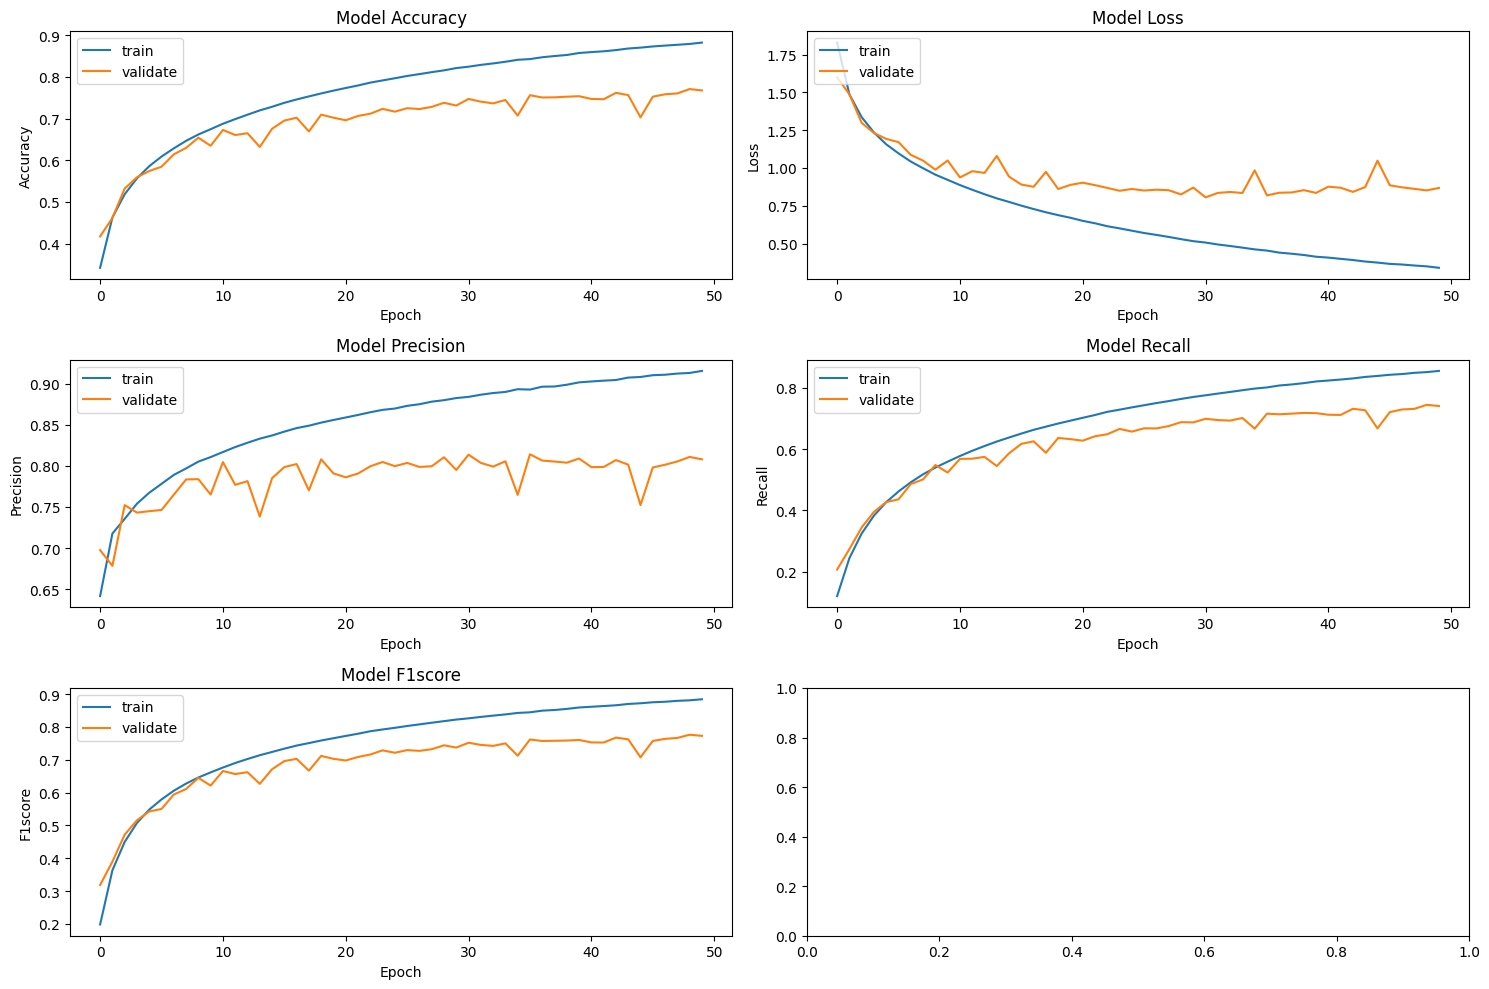

In [14]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Plot accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['train', 'validate'], loc='upper left')

    # Plot loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['train', 'validate'], loc='upper left')

    # Plot precision_m
    axs[1, 0].plot(history.history['precision_m'])
    axs[1, 0].plot(history.history['val_precision_m'])
    axs[1, 0].set_title('Model Precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['train', 'validate'], loc='upper left')

    # Plot recall_m
    axs[1, 1].plot(history.history['recall_m'])
    axs[1, 1].plot(history.history['val_recall_m'])
    axs[1, 1].set_title('Model Recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['train', 'validate'], loc='upper left')

    # Plot f1score_m
    axs[2, 0].plot(history.history['f1_m'])
    axs[2, 0].plot(history.history['val_f1_m'])
    axs[2, 0].set_title('Model F1score')
    axs[2, 0].set_ylabel('F1score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['train', 'validate'], loc='upper left')

    plt.tight_layout()
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [15]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_test, Y_test, verbose=0)
print("Loss of test set is: ",lost_test)
print("Accuracy of test set is: ",accuracy_test)
print("F1score of test set is: ",f1score_test)
print("Precision of test set is: ",precision_test)
print("Recall of test set is: ",recall_test)

Loss of test set is:  4.149653911590576
Accuracy of test set is:  0.3664883077144623
F1score of test set is:  0.36045917868614197
Precision of test set is:  0.3759027421474457
Recall of test set is:  0.348004013299942


### Draw confusion matrix

In [16]:
label

array(['right little', 'right middle', 'right ring', 'right thumb',
       'right index', 'left little', 'left middle', 'left ring',
       'left thumb', 'left index'], dtype='<U12')

In [17]:
labels = list(label)
labels

['right little',
 'right middle',
 'right ring',
 'right thumb',
 'right index',
 'left little',
 'left middle',
 'left ring',
 'left thumb',
 'left index']

9244/9244 [==============================] - 28s 3ms/step


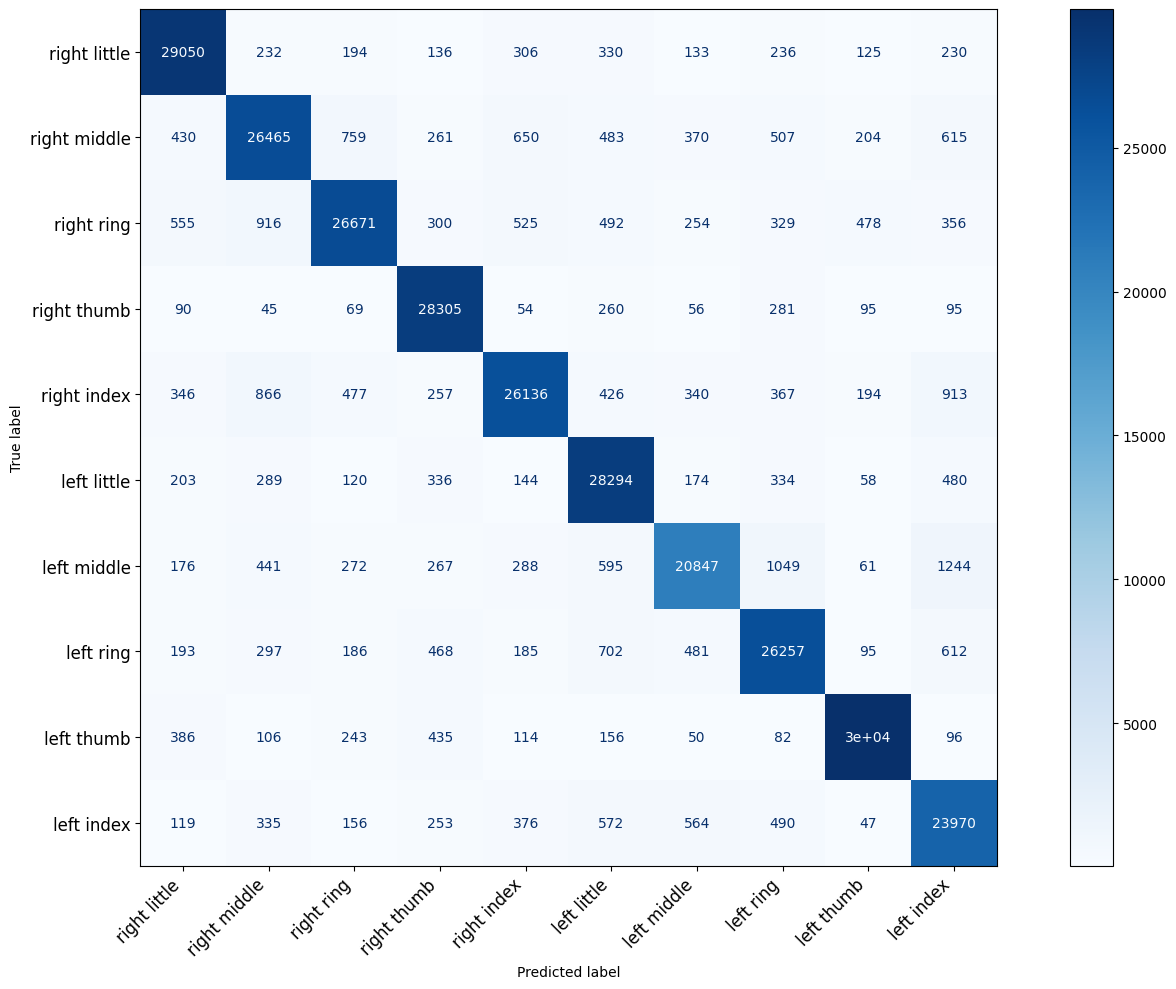

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_train, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


In [19]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((295791, 32, 32, 1), (295791, 10), (85970, 32, 32, 1), (85970, 10))

2687/2687 [==============================] - 8s 3ms/step


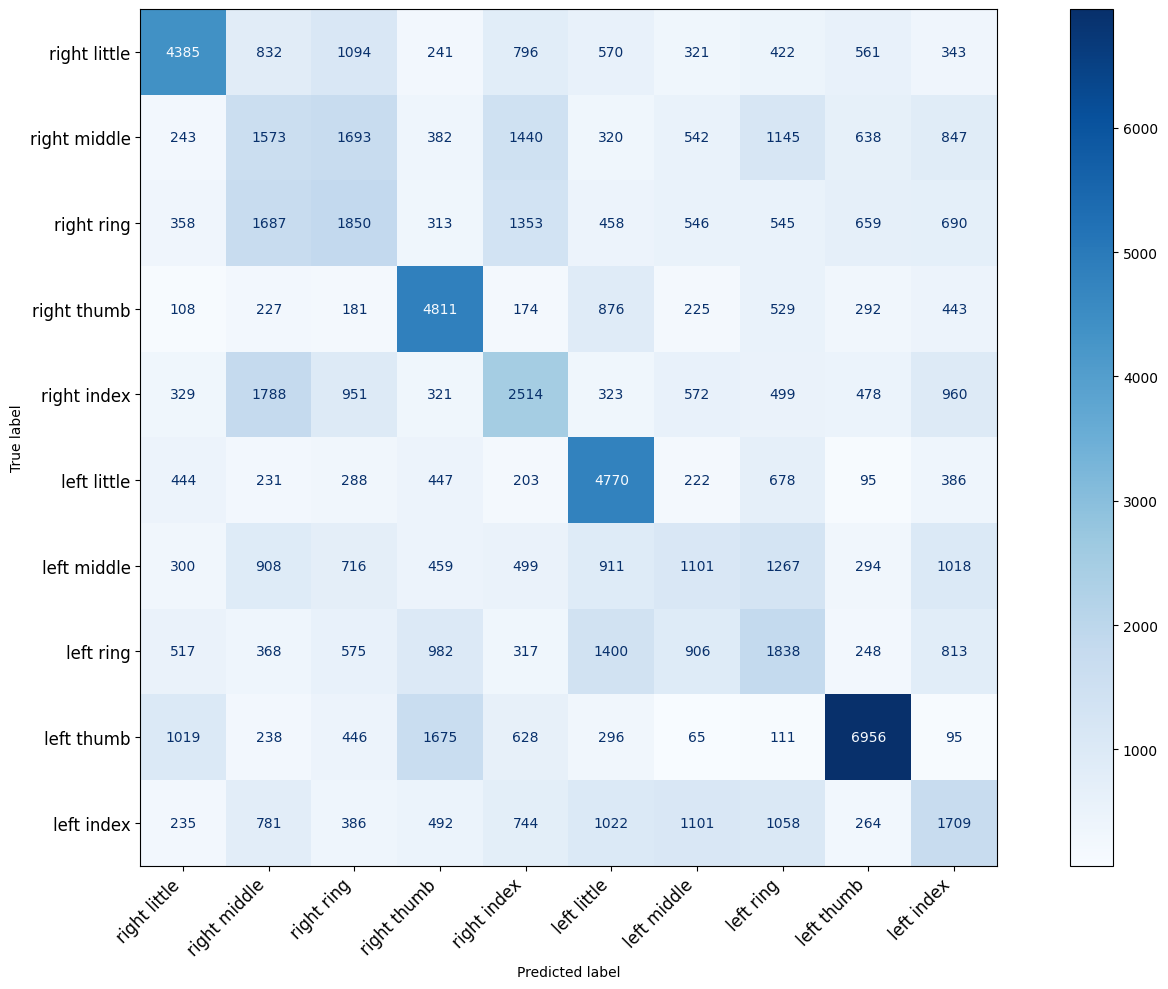

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()
